# Solving the KdV equation numerically

In [1]:
import autograd.numpy as np
from autograd import elementwise_grad
import numpy.linalg as la
from scipy.sparse import spdiags

import matplotlib.pyplot as plt
colors = [(0,0.4,1),(1,0.7,0.3),(0.2,0.7,0.2),(0.8,0,0.2),(0.5,0.3,.9)]

## The Korteweg–de Vries equation

In this notebook, we consider the one-dimensional forced Korteweg–de Vries (KdV) equation for waves on shallow water. It is given by
\begin{equation}
u_t + \eta u u_x + \gamma^2 u_{xxx} = g(x,t),
\label{eq:kdv} \tag{1}
\end{equation}
where $\eta, \gamma \in \mathbb{R}$. If $g(x,t) = 0$, we have the standard unforced KdV equation.

For the standard KdV equation, the energy given by
$$
\begin{align*}
\mathcal{H}[u] &= \int_\mathbb{R} \left(-\frac{\eta}{6} u^3 + \frac{\gamma^2}{2}u_x^2 \right)\, dx
\end{align*}
$$
is conserved, i.e. constant over time.

<details>
Let $\mathcal{H}$ be an integral of the function $u$, its spatial argument $x$, and the first derivative. Futhermore, let the integrand be denoted by $I$, so that
$$
\mathcal{H}[u] = \int_\mathbb{R} I(x,u,u_x) \, dx.
$$
The variational derivative (or functional derivative) of $\mathcal{H}$ is given by
$$
\frac{\delta \mathcal{H}}{\delta u}[u] = \frac{\partial I}{\partial u} - \frac{d}{dx} \frac{\partial I}{\partial u_x}.
$$

Side note: the variational derivative is the left hand side of the Euler--Lagrange equation.
</details>

The variational derivative of the energy is
$$
\begin{align*}
\frac{\delta\mathcal{H}}{\delta u}[u] &= - \frac{\eta}{2} u^2 - \gamma^2 u_{xx},\\
\end{align*}
$$
and the KdV equation may be expressed by a product of the skew-symmetric operator $\frac{\partial}{\partial x}$ and this variational derivative. That is,
\begin{equation}
u_t = - \frac{\partial}{\partial x} \left( \frac{\eta}{2} u^2 + \gamma^2 u_{xx} \right) + g(x,t),
\label{eq:kdvmod} \tag{2}
\end{equation}
which we see is equivalent to (1).

<details>
Consider a general first-order PDE
$$
u_t = f(x,u^J)
$$
where $u^J$ denotes $u$ itself and its spatial derivatives of any order. A first integral (sometimes called invariant or integeral of motion) of this is PDE a functional $\mathcal{H}[u]$ satisfying
$$
\left\langle \dfrac{\delta \mathcal{H}}{\delta u}[u], f(x,u^J) \right\rangle_{L^2}  = 0.
$$

We may observe that $\mathcal{H}[u]$ is preserved over time, since this implies
$$
\dfrac{\mathrm{d}\mathcal{H}}{\mathrm{d}t} = \left\langle \dfrac{\delta \mathcal{H}}{\delta u}[u], \dfrac{\partial u}{\partial t}\right\rangle_{L^2} = 0.
$$


Corresponding to any first integral there exists some operator $S(x,u^J)$, skew-symmetric with respect to the $L^2$ inner product, such that 
$$
f(x,u^J) = S(x,u^J)\dfrac{\delta \mathcal{H}}{\delta u}[u],
$$
Then we can state the PDE on the form
$$
u_t = S(x, u^J)\dfrac{\delta \mathcal{H}}{\delta u}[u].
$$
This can be considered as the PDE analogue of an ODE with a first integral, in which case we have a system
$$
\dfrac{\mathrm{d}y}{\mathrm{d}t} = S(y)\nabla H(y),
$$
where $S(y)$ is a skew-symmetric matrix.

Say that we have a spatial discretization of $u(x,t)$, which we also denote by $u(t) \in \mathbb{R}^M$. Consider a consistent quadrature approximation to $\mathcal{H}$, dependent on the discretization parameters $p$, denoted by $H_p$. We may replace the $L^2$ inner product by a discrete version and the variational derivative by the gradient (weighted with quadrature weights). Then a consistent spatial discretization of the PDE is given by
$$
u_t = S_p(u) \nabla H_p(u),
$$
where $S_p$ (weighted with quadrature weights) is a consistent approximation of $S$, skew-symmetric with respect to the discrete $L^2$ inner product.

For more details on the above, see e.g. https://doi.org/10.1007/s10444-017-9562-8.
</details>

### Analytic solution
The standard KdV equation has an analytic solution for some initial conditions. E.g. if the initial condition is a single wave of a certain shape, a so-called soliton, the wave will keep its original shape and move at a constant speed correpsonding to the height of the wave. That is, for the inital condition
$$
u(x,0) = \frac{1}{2} c \, \mathrm{sech}^2 (-x + P/2),
$$
and periodic boundary conditions $u(P,t) = u(0,t)$ for all $t\geq0$, the exact solution at all times is
$$
u(x,t) = \frac{1}{2} c \, \mathrm{sech}^2 (\lvert (x - c t) \, \mathrm{mod} \, P - P/2\rvert).
$$

In [2]:
def grid(P=20, M=100):
    dx = P/M
    x = np.linspace(0, P-dx, M)
    return x, dx

In [3]:
c = 4 # the speed, and two times the height of the wave
P = 20 # period
M = 100 # number of spatial points
x, dx = grid(P, M)
sech = lambda a: 1/np.cosh(a) # sech isn't defined in NumPy
u_soliton = lambda x, t: 1/2*c*sech(np.abs((x-c*t) % P - P/2))**2

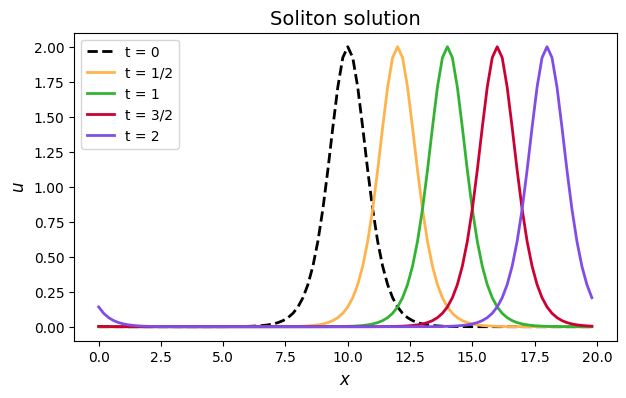

In [4]:
fig = plt.figure(figsize=(7,4))
lw = 2
plt.plot(x, u_soliton(x, 0), 'k--', linewidth=lw, label='t = 0')
plt.plot(x, u_soliton(x, 1/2), color = colors[1], linewidth=lw, label='t = 1/2')  
plt.plot(x, u_soliton(x, 1), color = colors[2], linewidth=lw, label='t = 1')  
plt.plot(x, u_soliton(x, 3/2), color = colors[3], linewidth=lw, label='t = 3/2')  
plt.plot(x, u_soliton(x, 2), color = colors[4], linewidth=lw, label='t = 2')  
plt.xlabel('$x$', fontsize=12)
plt.ylabel('$u$', fontsize=12)
plt.title('Soliton solution', fontsize=14)
plt.legend()
plt.show()

Observe that the height of the wave is $2 = \frac{c}{2}$, and the speed is $4=c$.

In general, however, the KdV equation does not have an analytic solution, and thus has to be solved by numerical methods.

## Discretizing in space

To solve any time-dependent PDE numerically, the standard approach is to first discretize in space and then in time. That is, given the initial condition, we choose which spatial points to evaluate the solution on and then we set up a system of ODEs that approximate the original PDE. Afterwards, when we discretize in time and integrate to predict future solutions, we only approximate the solution at these given points.

Say then that we have $M+1$ equally spaced grid points on the domain $\left[0,P\right]$. Because we assume periodic boundary conditions, we only use the $M$ first points, and the space between each grid point is $\Delta x = P/M$. This gives us the semi-discrete (discrete in space, continuous in time) solution vector
\begin{align}
\mathbf{u}(t) = 
\begin{pmatrix}
    u_0(t) \\
    u_1(t) \\
    \vdots \\
    u_{M-1}(t)
\end{pmatrix},
\end{align}
where each element $u_i(t) = u(x_i,t)$, i.e. the solution at the $i$th grid point $x_i = i \Delta x$.

**Note:** We use boldface here to denote a vector and distinguish $\mathbf{u}(t)$ from the fully continuous $u(x,t)$. However, we will often use $u$ also for the vector-valued function $u(t)$.

#### Finite difference operators and matrices

The spatial derivatives $u_x$, $u_{xx}$ and so on are not defined for the time-discrete function $\mathbf{u}(t)$, so these need to be approximated. We approximate them using <a href='https://en.wikipedia.org/wiki/Finite_difference'>finite differences</a> on the grid. We choose to use the central difference operator for both the first and second derivative:
\begin{align}
\frac{\partial}{\partial x} u_i &\approx \delta^1_c u_i := \frac{u_{i+1}-u_{i-1}}{x_{i+1}-x_{i-1}} = \frac{1}{2 \Delta x} (u_{i+1}-u_{i-1})\\
\frac{\partial^2}{\partial x^2} u_i &\approx \delta^2_c u_i := \frac{\frac{u_{i+1}-u_{i}}{x_{i+1}-x_{i}} - \frac{u_{i}-u_{i-1}}{x_{i}-x_{i-1}}}{x_{i+1/2}-x_{i-1/2}} = \frac{1}{(\Delta x)^2} (u_{i+1}-2u_i+u_{i-1})
\end{align}

<details>
Just as for the original derivative operators, we could also multiply the finite difference operators. That is, since $\frac{\partial^2}{\partial x^2} = \frac{\partial}{\partial x} \frac{\partial}{\partial x}$, we could approximate $\frac{\partial^2}{\partial x^2}$ by $\delta^1_c\delta^1_c$, which is a different approximation than $\delta^2_c := \delta^1_f \delta^1_b$. However, we will use $\delta^3_c := \delta_c\delta^2_c$ to approximate $\frac{\partial^3}{\partial x^3}$.
</details>


Since the finite difference operators are linear, there exist corresponding matrices that can be applied to the vector $\mathbf{u}$ instead of the operator. For the first and second order operators, we have
\begin{align}
\delta^1_c \mathbf{u} 
& = \delta^1_c
\begin{pmatrix}
    u_0 \\
    u_1 \\
    u_2 \\
    \vdots \\
    u_{M-2} \\
    u_{M-1}
\end{pmatrix}
= \frac{1}{2 \Delta x}
\begin{pmatrix}
    u_1 - u_{M-1} \\
    u_2 - u_0 \\
    u_3 - u_1 \\
    \vdots \\
    u_{M-1} - u_{M-3} \\
    u_0 - u_{M-2}
\end{pmatrix}
 = \frac{1}{2 \Delta x}
\begin{pmatrix}
    0 & 1 & 0 & 0 & \ldots & -1 \\
    -1 & 0 & 1 & 0 & \ldots & 0 \\
    0 & -1 & 0 & 1 & \ldots & 0 \\
    & & \ddots & \ddots & \ddots & \\
    0 & \ldots & 0 & -1 & 0 & 1 \\
    1 & \ldots & 0 & 0 & -1 & 0
\end{pmatrix}
\begin{pmatrix}
    u_0 \\
    u_1 \\
    u_2 \\
    \vdots \\
    u_{M-2} \\
    u_{M-1}
\end{pmatrix}
=: D^1_c \mathbf{u}
\end{align}

and

\begin{align}
\delta^2_c \mathbf{u} 
& = \delta^2_c
\begin{pmatrix}
    u_0 \\
    u_1 \\
    u_2 \\
    \vdots \\
    u_{M-2} \\
    u_{M-1}
\end{pmatrix}
= \frac{1}{(\Delta x)^2}
\begin{pmatrix}
    u_1 - 2 u_0 + u_{M-1} \\
    u_2 - 2 u_1 + u_0 \\
    u_3 - 2 u_2 + u_1 \\
    \vdots \\
    u_{M-1} - 2u_{M-2} + u_{M-3} \\
    u_0 - 2 u_{M-1} + u_{M-2}
\end{pmatrix}
 = \frac{1}{(\Delta x)^2}
\begin{pmatrix}
    -2 & 1 & 0 & 0 & \ldots & 1 \\
    1 & -2 & 1 & 0 & \ldots & 0 \\
    0 & 1 & -2 & 1 & \ldots & 0 \\
    & & \ddots & \ddots & \ddots & \\
    0 & \ldots & 0 & 1 & -2 & 1 \\
    1 & \ldots & 0 & 0 & 1 & -2
\end{pmatrix}
\begin{pmatrix}
    u_0 \\
    u_1 \\
    u_2 \\
    \vdots \\
    u_{M-2} \\
    u_{M-1}
\end{pmatrix}
=: D^2_c \mathbf{u}
\end{align}

<details>
Like for the operators, we get the matrix for the third order finite difference by $D^3_c := D^1_c D^2_c$.
</details>

In [5]:
def difference_matrices(P=20, M=100):
    dx = P/M
    e = np.ones(M) # unit vector of length M
    # 1st order central difference matrix:
    D1 = .5/dx*spdiags([e,-e,e,-e], np.array([-M+1,-1,1,M-1]), M, M).toarray()
    # 2nd order central difference matrix:
    D2 = 1/dx**2*spdiags([e,e,-2*e,e,e], np.array([-M+1,-1,0,1,M-1]), M, M).toarray()
    return D1, D2

In [6]:
D1, D2 = difference_matrices(10, 10)
print('D1 =\n', D1)
print('\nD2 =\n', D2)

D1 =
 [[ 0.   0.5  0.   0.   0.   0.   0.   0.   0.  -0.5]
 [-0.5  0.   0.5  0.   0.   0.   0.   0.   0.   0. ]
 [ 0.  -0.5  0.   0.5  0.   0.   0.   0.   0.   0. ]
 [ 0.   0.  -0.5  0.   0.5  0.   0.   0.   0.   0. ]
 [ 0.   0.   0.  -0.5  0.   0.5  0.   0.   0.   0. ]
 [ 0.   0.   0.   0.  -0.5  0.   0.5  0.   0.   0. ]
 [ 0.   0.   0.   0.   0.  -0.5  0.   0.5  0.   0. ]
 [ 0.   0.   0.   0.   0.   0.  -0.5  0.   0.5  0. ]
 [ 0.   0.   0.   0.   0.   0.   0.  -0.5  0.   0.5]
 [ 0.5  0.   0.   0.   0.   0.   0.   0.  -0.5  0. ]]

D2 =
 [[-2.  1.  0.  0.  0.  0.  0.  0.  0.  1.]
 [ 1. -2.  1.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  1. -2.  1.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  1. -2.  1.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  1. -2.  1.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  1. -2.  1.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  1. -2.  1.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  1. -2.  1.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  1. -2.  1.]
 [ 1.  0.  0.  0.  0.  0.  0.  0.  1. -2.]]


We can visually compare how well these approximations are, e.g for the initial condition of the soliton solution:

In [7]:
M = 50 # increase or decrease M to see how the approximation gets better/worse
x, dx = grid(P, M)
D1, D2 = difference_matrices(P,M)

In [8]:
u0 = lambda x: u_soliton(x,0)
du0 = elementwise_grad(u0) # analytic first derivative
Du0 = np.matmul(D1, u0(x)) # finite difference approximation of the first derivative
ddu0 = elementwise_grad(du0) # analytic second derivative
DDu0 = np.matmul(D2, u0(x)) # finite difference approximation of the second derivative

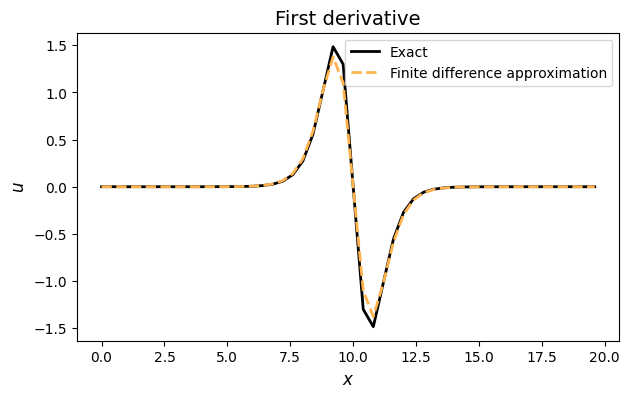

In [9]:
fig = plt.figure(figsize=(7,4))
lw = 2
plt.plot(x, du0(x), 'k', linewidth=lw, label='Exact')
plt.plot(x, Du0, color=colors[1], linestyle='--', linewidth=lw, label='Finite difference approximation')
plt.xlabel('$x$', fontsize=12)
plt.ylabel('$u$', fontsize=12)
plt.title('First derivative', fontsize=14)
plt.legend()
plt.show()

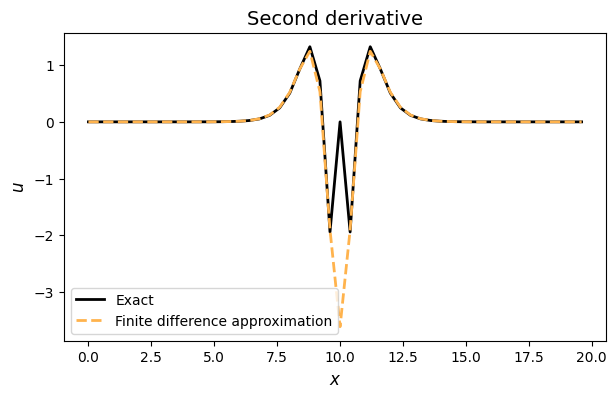

In [10]:
fig = plt.figure(figsize=(7,4))
lw = 2
plt.plot(x, ddu0(x), 'k', linewidth=lw, label='Exact')
plt.plot(x, DDu0, color=colors[1], linestyle='--', linewidth=lw, label='Finite difference approximation')
plt.xlabel('$x$', fontsize=12)
plt.ylabel('$u$', fontsize=12)
plt.title('Second derivative', fontsize=14)
plt.legend()
plt.show()





### Semi-discrete formulation as a system of ODEs

Using these operators to approximate the spatial derivatives of (2), we get
\begin{equation}
\mathbf{u}_t = - D_c^1 (\frac{\eta}{2} \mathbf{u}^2 + \gamma^2 D_c^2 \mathbf{u}) + \mathbf{g}(t),
\label{eq:kdv_disc} \tag{3}
\end{equation}
where
\begin{align}
\mathbf{g}(t) = 
\begin{pmatrix}
    g(x_0,t) \\
    g(x_1,t) \\
    \vdots \\
    g(x_{M-1},t)
\end{pmatrix},
\end{align}
and $\mathbf{u}^2$ is the element-wise square of $\mathbf{u}$.

<details>
The approximation of (1) given by
$$
\mathbf{u}_t + \frac{\eta}{2} D_c^1 \mathbf{u}^2 + \gamma^2 D_c^3 \mathbf{u} = \mathbf{g}(t)
$$
is fully equivalent.
</details>

In [11]:
# At this point we need to decide on the grid that we want to use in the time-integration to follow:
P = 20
M = 100 # increase or decrease M to see how the approximation gets better/worse
x, dx = grid(P, M)
D1, D2 = difference_matrices(P,M)

In [12]:
# We must also define the system (1) by defining g and the parameters:
g = lambda x, t: 0
eta = 6.
gamma = 1.

In [13]:
# Define f so that u_t = f is (3)
f = lambda u, t: -np.matmul(D1, .5*eta*u**2 + gamma**2*np.matmul(D2,u)) + g(x, t)

We now have a system of ODEs (3) which we may solve with the appropriate numerical integrator, or scheme, to predict the future solutions of $\mathbf{u}(t)$.

## Integration in time

The most simple numerical integrator for solving the general ODE
$$
u_t = f(u,t)
$$
is the forward Euler method
$$
\frac{u^{n+1}-u^n}{\Delta t} = f(u^n, t^n).
$$
Note that we use superscript for the indices of the temporal discretization while we use subscripts for the spatial discretization.

Using the forward Euler method, we find the solution in the next time step by $u^{n+1} = u^n + \Delta t f(u^n, t^n)$. This integrator is explicit, in the sense that $u^{n+1}$ is given explicitly by the scheme and the current solution $u^n$.

In [14]:
# Choose the times to integrate over:
t_max = 2
N = 10000
t, dt = grid(t_max, N)

In [15]:
u0 = u_soliton(x,0)

In [16]:
u = np.zeros([t.shape[0], u0.shape[-1]])
u[0, :] = u0

In [17]:
# Forward Euler:
for i, t_step in enumerate(t[:-1]):
    u[i+1,:] = u[i,:] + dt*f(u[i,:], t[i])

/var/folders/qt/5hnkklzx3qz34g37fvg7b2h80000gn/T/ipykernel_74720/1685264639.py:2: RuntimeWarning: overflow encountered in square
  f = lambda u, t: -np.matmul(D1, .5*eta*u**2 + gamma**2*np.matmul(D2,u)) + g(x, t)
/usr/local/Caskroom/miniforge/base/envs/phnn_oct/lib/python3.9/site-packages/autograd/tracer.py:48: RuntimeWarning: invalid value encountered in matmul
  return f_raw(*args, **kwargs)


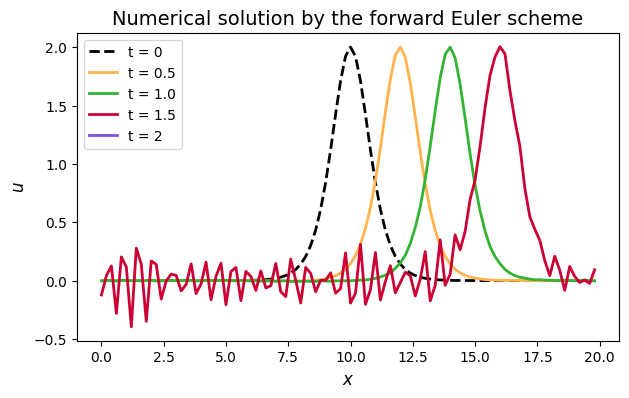

In [18]:
fig = plt.figure(figsize=(7,4))
lw = 2
plt.plot(x, u[0,:], 'k--', linewidth=lw, label='t = 0')
plt.plot(x, u[int(N/4),:], color = colors[1], linewidth=lw, label=f't = {1/4*t_max}')  
plt.plot(x, u[int(N/2),:], color = colors[2], linewidth=lw, label=f't = {1/2*t_max}')  
plt.plot(x, u[int(3*N/4),:], color = colors[3], linewidth=lw, label=f't = {3/4*t_max}')  
plt.plot(x, u[-1,:], color = colors[4], linewidth=lw, label=f't = {t_max}')  
plt.xlabel('$x$', fontsize=12)
plt.ylabel('$u$', fontsize=12)
plt.title('Numerical solution by the forward Euler scheme', fontsize=14)
plt.legend()
plt.show()

We see that the Euler method gets unstable, even if we use very small time steps. More advanced explicit integrators, like the classic fourth-order Runge–Kutta method or variants of it, are usually implemented in python functions like `scipy.integrate.solve_ivp`. However, explicit integrators are generally ill-suited to solve the KdV equation.

### The implicit midpoint method

The implicit midpoint method
$$
\frac{u^{n+1}-u^n}{\Delta t} = f(\frac{u^n+u^{n+1}}{2}, \frac{t^n+t^{n+1}}{2}),
$$
har certain properties that make it well-suited for the KdV equation. Most importantly, it is symplectic. That means that fort he standard unforced KdV equation, a discrete approximation of the energy will be preserved (within some time-independent bound) at all times. This guarantees stability. To find $u^{n+1}$ from the implicit midpoint method we define
\begin{equation}
F(\hat{u}) := \frac{\hat{u}-u^n}{\Delta t} - f(\frac{u^n+\hat{u}}{2}, \frac{t^n+t^{n+1}}{2}),
\label{eq:F} \tag{4}
\end{equation}
and must solve the optimization problem $F(\hat{u}) = 0$ for $\hat{u}$.

### Newton's method

We wish to use <a href='https://en.wikipedia.org/wiki/Newton%27s_method'>Newton's method</a> to find the root of $F$. That is, starting from the initial guess $\hat{u}^0$, which we generally set to be $u^n$, we iteratively find better approximations by
$$
\hat{u}^{j+1} = \hat{u}^{j} - \frac{F(\hat{u}^{j})}{F'(\hat{u}^{j})}
$$
until we have $\lvert F(\hat{u}^{j+1}) \rvert < \epsilon$ for some tolerance $\epsilon$, or a maximum number of iterations have been performed.

For (4), we get
\begin{equation}
F'(\hat{u}) = \frac{1}{\Delta t} - \frac{\partial}{\partial \hat{u}} f(\frac{u^n + \hat{u}}{2}, \frac{t^n + t^{n+1}}{2})
= \frac{1}{\Delta t} - \frac{1}{2} \frac{\partial}{\partial u} f(u, t)\Big\rvert_{u=\frac{u^n + \hat{u}}{2}, \, t=\frac{t^n + t^{n+1}}{2}} 
\label{eq:Fd} \tag{5}
\end{equation}

For the KdV midpoint scheme, we have
$$
f(\mathbf{u}, t) = - D_c^1 (\frac{\eta}{2} \mathbf{u}^2 + \gamma^2 D_c^2 \mathbf{u}) + \mathbf{g}(t)
$$
and
$$
\frac{\partial}{\partial \mathbf{u}} f(\mathbf{u}, t) = - D_c^1 (\eta \, \mathrm{diag}(\mathbf{u)} + \gamma^2 D_c^2),
$$
where $\mathrm{diag}(\mathbf{u})$ is an $M \times M$ diagonal matrix with $\mathbf{u}$ on the diagonal.

<details>
If we write out (4) and (5) for the KdV scheme we get
\begin{align}
F(\mathbf{\hat{u}}) &= \frac{\mathbf{\hat{u}} + \mathbf{u}^n}{\Delta t} - D_c^1 \Big(\frac{\eta}{2} \big(\frac{\mathbf{u}^n+\mathbf{\hat{u}}}{2}\big)^2 + \gamma^2 D_c^2 \frac{\mathbf{u}^n+\mathbf{\hat{u}}}{2}\Big) + \mathbf{g}\big(\frac{t^n+t^{n+1}}{2}\big)\\
F'(\mathbf{\hat{u}}) & = \frac{1}{\Delta t} I + \frac{1}{2} D_c^1 (\eta \, \mathrm{diag}\big(\frac{\mathbf{u}^n+\mathbf{\hat{u}}}{2}\big) + \gamma^2 D_c^2)
\end{align}
where $I$ is the $M$-dimensional identity matrix. But in the code we'll set up (4) and (5) and give them $f$ and $\frac{\partial}{\partial \mathbf{u}} f$.
</details>

In [19]:
# u0 = u_soliton(x,0) # same as above
# f = lambda u, t: -np.matmul(D1, .5*eta*u**2 + gamma**2*np.matmul(D2,u)) # same as above
Df = lambda u: -np.matmul(D1, eta*np.diag(u) + gamma**2*D2)

In [20]:
def midpoint_method(u,un,t,f,Df,dt,M,tol,max_iter):
    '''
    Integrating one step of the ODE u_t = f, from u to un,
    with the implicit midpoint method
    Using Newton's method to find un
    '''
    I = np.eye(M)
    F = lambda u_hat: 1/dt*(u_hat-u) - f((u+u_hat)/2, t+.5*dt)
    J = lambda u_hat: 1/dt*I - 1/2*Df((u+u_hat)/2)
    err = la.norm(F(un))
    it = 0
    while err > tol:
        un = un - la.solve(J(un),F(un))
        err = la.norm(F(un))
        it += 1
        if it > max_iter:
            break
    return un

In [21]:
t_max = 2
N = 100
t, dt = grid(t_max, N)
u = np.zeros([t.shape[0], u0.shape[-1]])
u[0, :] = u0

In [22]:
# The implicit midpoint method:
for i, t_step in enumerate(t[:-1]):
    u[i+1,:] = midpoint_method(u[i,:], u[i,:], t[i], f, Df, dt, M, 1e-12, 5)

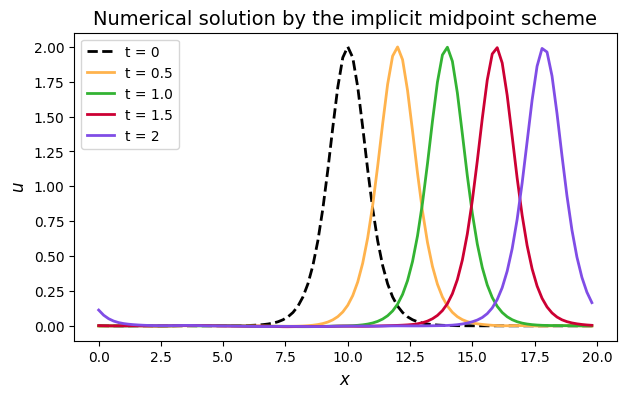

In [23]:
fig = plt.figure(figsize=(7,4))
lw = 2
plt.plot(x, u[0,:], 'k--', linewidth=lw, label='t = 0')
plt.plot(x, u[int(N/4),:], color = colors[1], linewidth=lw, label=f't = {1/4*t_max}')  
plt.plot(x, u[int(N/2),:], color = colors[2], linewidth=lw, label=f't = {1/2*t_max}')  
plt.plot(x, u[int(3*N/4),:], color = colors[3], linewidth=lw, label=f't = {3/4*t_max}')  
plt.plot(x, u[-1,:], color = colors[4], linewidth=lw, label=f't = {t_max}')  
plt.xlabel('$x$', fontsize=12)
plt.ylabel('$u$', fontsize=12)
plt.title('Numerical solution by the implicit midpoint scheme', fontsize=14)
plt.legend()
plt.show()

## A more advanced problem

Let us then consider also problems that do not have an analytic solution, e.g. a system with two waves:

In [65]:
def initial_condition_kdv(x=np.linspace(0,20.-.2,100), eta=6.):
    M = x.size
    P = int((x[-1]-x[0])*M/(M-1))
    k1, k2 = 1., .75
    d1, d2 = .25, .5
    u0 = 0
    u0 += (-6./-eta)*2 * k1**2 * sech(np.abs(k1 * ((x+P/2-P*d1) % P - P/2)))**2
    u0 += (-6./-eta)*2 * k2**2 * sech(np.abs(k2 * ((x+P/2-P*d2) % P - P/2)))**2
    u0 = np.concatenate([u0[M:], u0[:M]], axis=-1)
    return u0

Define the spatial grid:

In [66]:
P = 20
M = 100 # increase or decrease M to see how the approximation gets better/worse
x, dx = grid(P, M)
D1, D2 = difference_matrices(P,M)

In [67]:
u0 = initial_condition_kdv(x, eta)

And let us also consider the case of an external force acting on the system:

In [68]:
# g = lambda x, t: 3*np.sin(2*np.pi*t)
# g = lambda x, t: np.sin(2*np.pi/P*x)*np.ones_like(t)
g = lambda x, t: 0*np.sin(2*np.pi/P*x)*np.sin(2*np.pi*t)
f = lambda u, t: -np.matmul(D1, .5*eta*u**2 + gamma**2*np.matmul(D2,u)) + g(x, t)
Df = lambda u: -np.matmul(D1, eta*np.diag(u) + gamma**2*D2)

Define the temporal grid:

In [69]:
t_max = 1
N = 100
t, dt = grid(t_max, N)

Integrate with the implicit midpoint method:

In [70]:
u = np.zeros([t.shape[0], u0.shape[-1]])
u[0, :] = u0
for i, t_step in enumerate(t[:-1]):
    u[i+1,:] = midpoint_method(u[i,:], u[i,:], t[i], f, Df, dt, M, 1e-12, 5)

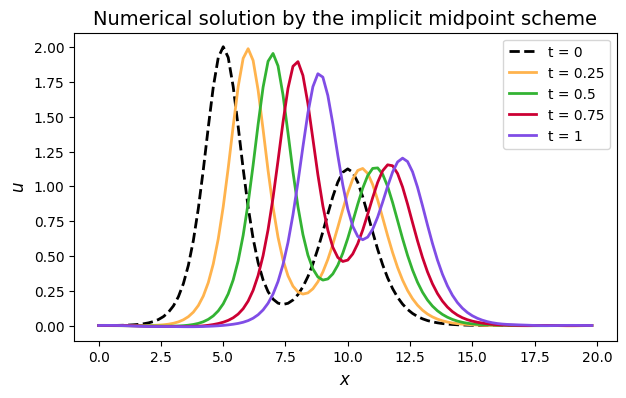

In [71]:
fig = plt.figure(figsize=(7,4))
lw = 2
plt.plot(x, u[0,:], 'k--', linewidth=lw, label='t = 0')
plt.plot(x, u[int(N/4),:], color = colors[1], linewidth=lw, label=f't = {1/4*t_max}')  
plt.plot(x, u[int(N/2),:], color = colors[2], linewidth=lw, label=f't = {1/2*t_max}')  
plt.plot(x, u[int(3*N/4),:], color = colors[3], linewidth=lw, label=f't = {3/4*t_max}')  
plt.plot(x, u[-1,:], color = colors[4], linewidth=lw, label=f't = {t_max}')  
plt.xlabel('$x$', fontsize=12)
plt.ylabel('$u$', fontsize=12)
plt.title('Numerical solution by the implicit midpoint scheme', fontsize=14)
plt.legend()
plt.show()